> &nbsp;  
> The next two functions (`get_env_type` and `print_versions_and_GPU`) are used because the notebook was developed/run on different environments. They do not contribute to the actual exercise.  
> &nbsp;  

In [1]:
def get_env_type() -> str:
    '''
    Get the environment type where the code is running.

    Returns:
    - 'kaggle' if running on Kaggle
    - 'google.colab' if running on Google Colab
    - 'local' if running on local environment
    '''
    import os, sys
    if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
        return 'kaggle'
    elif 'google.colab' in sys.modules:
        if 'COLAB_TPU_ADDR' in os.environ:  # Google Colab w/ TPU
            # Connect to TPU
            import tensorflow
            tpu = tensorflow.distribute.cluster_resolver.TPUClusterResolver()
            tensorflow.config.experimental_connect_to_cluster(tpu)
            tensorflow.tpu.experimental.initialize_tpu_system(tpu)
        # Connect to Drive
        from google.colab import drive
        drive.mount('/content/drive')
        return 'google.colab'
    else:   # Running on local environment
        return 'local'

def print_versions_and_GPU() -> None:
    '''
    Prints version numbers for various modules and GPU information (if available).
    '''
    import sys, tensorflow, sklearn
    print(f'Python: {sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}')
    print(f'TensorFlow: {tensorflow.__version__}')
    try:
        print(f'Keras: {tensorflow.keras.version()}')
    except:
        print(f'Keras: Unknown version')
    print(f'Scikit-learn: {sklearn.__version__}')
    gpus = tensorflow.config.list_physical_devices('GPU')
    if gpus is None:
        gpus = tensorflow.test.gpu_device_name()
    print(f'GPUs: {gpus if gpus else "None"}')

In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.figure import Figure
from typing import List, Dict, Tuple
import sklearn
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [3]:
print_versions_and_GPU()

Python: 3.11.5
TensorFlow: 2.16.1
Keras: 3.1.1
Scikit-learn: 1.2.2
GPUs: None


In [4]:
# Determine the environment we're running on.
match get_env_type():
    case 'kaggle':
        raise ValueError('This notebook is not designed to run on Kaggle.')
    case 'google.colab':
        data_path = '/content/drive/MyDrive/data/historical_structures_classification/data'
        models_path = '/content/drive/MyDrive/data/historical_structures_classification/models'
        max_epochs = 200 # Should never reach that high
    case 'local':
        data_path = './data'
        max_epochs = 3
    case _:
        raise ValueError(f'Unknown environment type: {get_env_type()}')

print(f'Running on {get_env_type()}')

Running on local


# Deep Learning

1. Plot the sample images (8–10) from each class or category to gain a better understanding of each class.

   __Hint__: You can use OpenCV open-source library for this task

> &nbsp;  
> Because of familiarity with Pillow, this library will be used instead of OpenCV.  
> &nbsp;


In [5]:
def load_images(src_folder: str, file_extension: str, delete_if_bad: bool = True) -> pd.DataFrame:
    images = []
    labels = []
    shapes = []
    channels = []
    for lbl in os.listdir(src_folder):
        lbl_dir = f'{src_folder}/{lbl}'
        for img in [img for img in os.listdir(lbl_dir) if img.endswith(file_extension)]:
            img_path = f'{lbl_dir}/{img}'
            try:
                temp = Image.open(img_path)
                images.append(img_path)
                labels.append(lbl)
                shapes.append(temp.size)
                channels.append(len(temp.getbands()))
                temp.close()
            except (OSError, IOError) as exc:
                print(f'Error loading image: {img_path}: {exc}')
                if delete_if_bad:
                    os.remove(img_path)
    return pd.DataFrame({'image': images, 'label': labels, 'shape': shapes, 'channels': channels})

In [6]:
df_train = load_images(f'{data_path}/structures/train', '.jpg')

df_train['label'] = df_train['label'].astype('category')

In [7]:
display(list(dict(df_train['label'].value_counts()).keys()))

['column',
 'gargoyle',
 'dome(outer)',
 'vault',
 'bell_tower',
 'stained_glass',
 'altar',
 'dome(inner)',
 'apse',
 'flying_buttress',
 'portal']

In [8]:
def counts_and_distributions(df: pd.DataFrame, title: str) -> None:
    plt.figure(figsize=(9, 6))
    plt.suptitle(f'{title}: Counts and Distributions')
    plt.subplot(3, 2, 1)
    plt.pie(df['label'].value_counts(), labels=list(dict(df['label'].value_counts()).keys()), autopct='%1.1f%%')
    plt.title('Labels', fontstyle='italic')
    plt.subplot(3, 2, 2)
    plt.pie(df['shape'].value_counts(), labels=list(dict(df['shape'].value_counts()).keys()), autopct='%1.1f%%')
    plt.title('Image Shapes', fontstyle='italic')
    plt.subplot(3, 2, 3)
    plt.pie(df['channels'].value_counts(), labels=list(dict(df['channels'].value_counts()).keys()), autopct='%1.1f%%')
    plt.title('Image Channels', fontstyle='italic')
    plt.subplot(3, 2, 4)
    if (df.isna().sum().sum() > 0):
        plt.pie(df.isna().sum(), labels=df.isna().sum().index, autopct='%1.1f%%')
    else:
        plt.text(0.5, 0.5, 'No missing values', horizontalalignment='center', verticalalignment='center', fontsize=12, color='green', fontstyle='italic')
        plt.axis('off')
    plt.title('Missing values', fontstyle='italic')
    plt.subplot(3, 2, 5)
    if (df.duplicated().sum() > 0):
        plt.pie(df.duplicated().sum(), labels=['Duplicated'], autopct='%1.1f%%')
    else:
        plt.text(0.5, 0.5, 'No duplicated values', horizontalalignment='center', verticalalignment='center', fontsize=12, color='green', fontstyle='italic')
        plt.axis('off')
    plt.title('Duplicated values', fontstyle='italic')
    plt.tight_layout()
    plt.show()


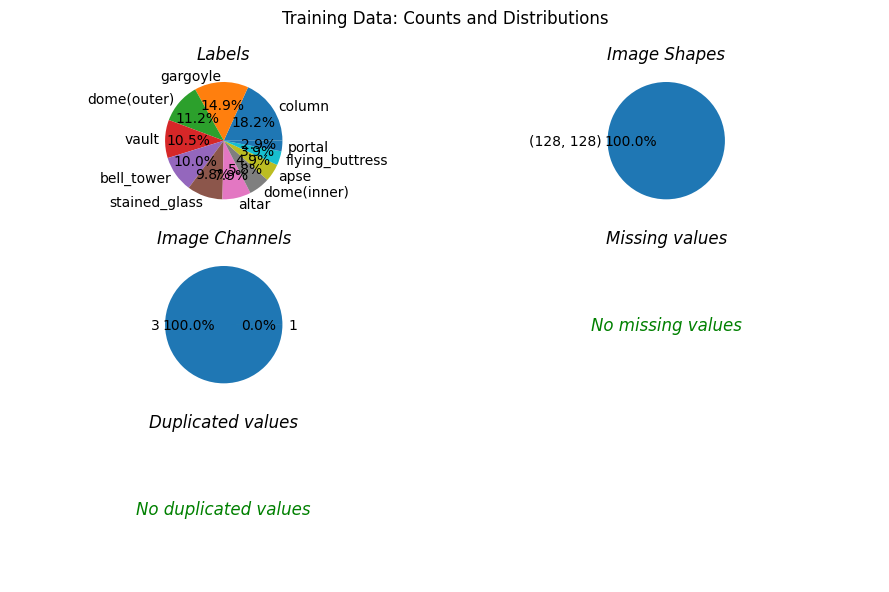

In [9]:
counts_and_distributions(df_train, 'Training Data')

In [10]:
# There are some images with different channels, we will remove them
df_train = df_train[df_train['channels'] == 3]

> &nbsp;  
> Consistent image size (128 x 128 with 3 channels), except for a very small number that only has 1 channel.  
> &nbsp;  
> Very imbalanced classes.  We should really use some kind of data augmentation to rebalance things.  
> &nbsp;  
> No Missing or Duplicated data.  
> &nbsp;  

In [11]:
# Display n random images from each label from the dataframe
def display_images(df: pd.DataFrame, n: int, subtitle: str) -> None:
    labels = df['label'].unique()
    fig = plt.figure(figsize=(1.3*n, 1.3 * len(labels)), layout='constrained')
    fig.suptitle(f'Sample Images : {subtitle}', fontsize=16)
    subfigs = fig.subfigures(nrows=len(labels), ncols=1)
    for l, lbl in enumerate(labels):
        lbl_df = df[df['label'] == lbl]
        subfigs[l].suptitle(lbl, fontsize=12)
        for i, id in enumerate(np.random.choice(len(lbl_df), n, replace=False)):
            sp = subfigs[l].add_subplot(1, n, i+1)
            sp.imshow(Image.open(lbl_df.iloc[id]['image']))
            sp.axis('off')
    plt.show()

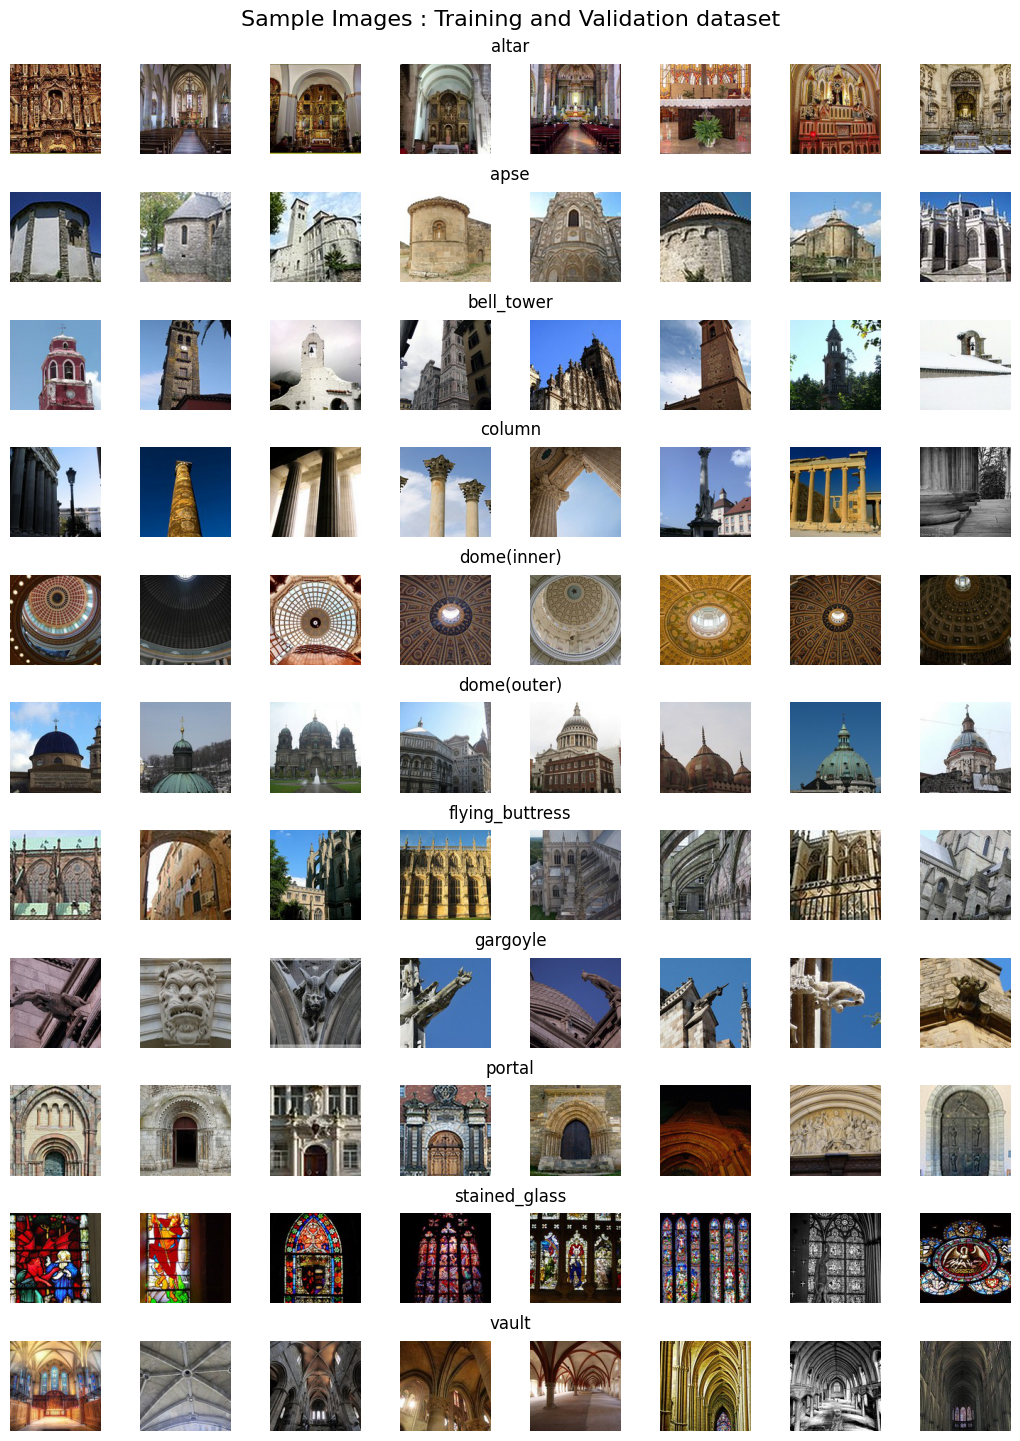

In [12]:
display_images(df_train, 8, 'Training and Validation dataset')

In [13]:
# Split the train dataset into train and validation datasets
df2_train, df2_valid = train_test_split(df_train, test_size=0.2, random_state=42, stratify=df_train['label'])

# Create the image data generator without augmentation for the train and validation datasets
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df2_train,
    x_col='image',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=128,
    shuffle=True,
    seed=42
)

valid_datagen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=df2_valid,
    x_col='image',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=128,
    shuffle=False,
    seed=42
)


Found 8433 validated image filenames belonging to 11 classes.
Found 2109 validated image filenames belonging to 11 classes.


In [14]:
df_test = load_images(f'{data_path}/structures/test', '.jpg')

df_test['label'] = df_test['label'].astype('category')

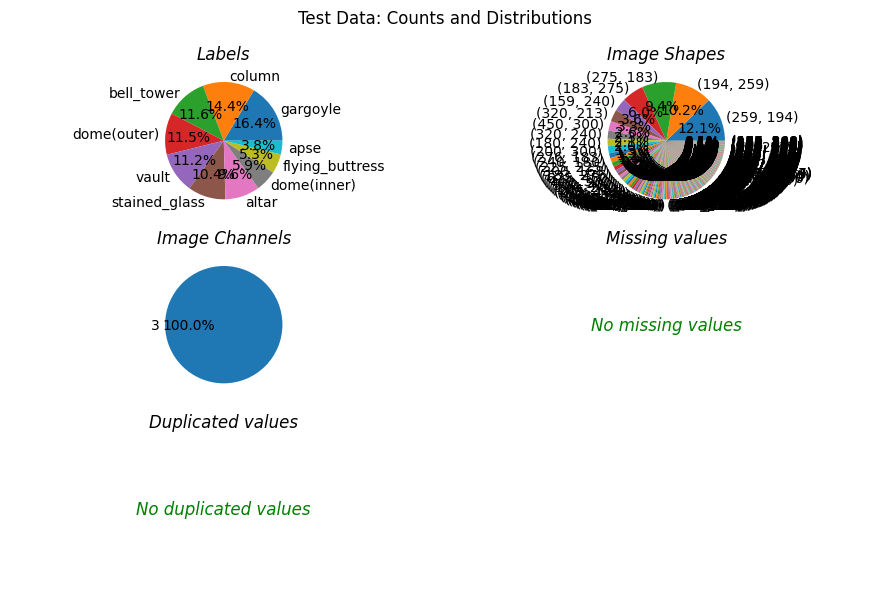

In [15]:
counts_and_distributions(df_test, 'Test Data')

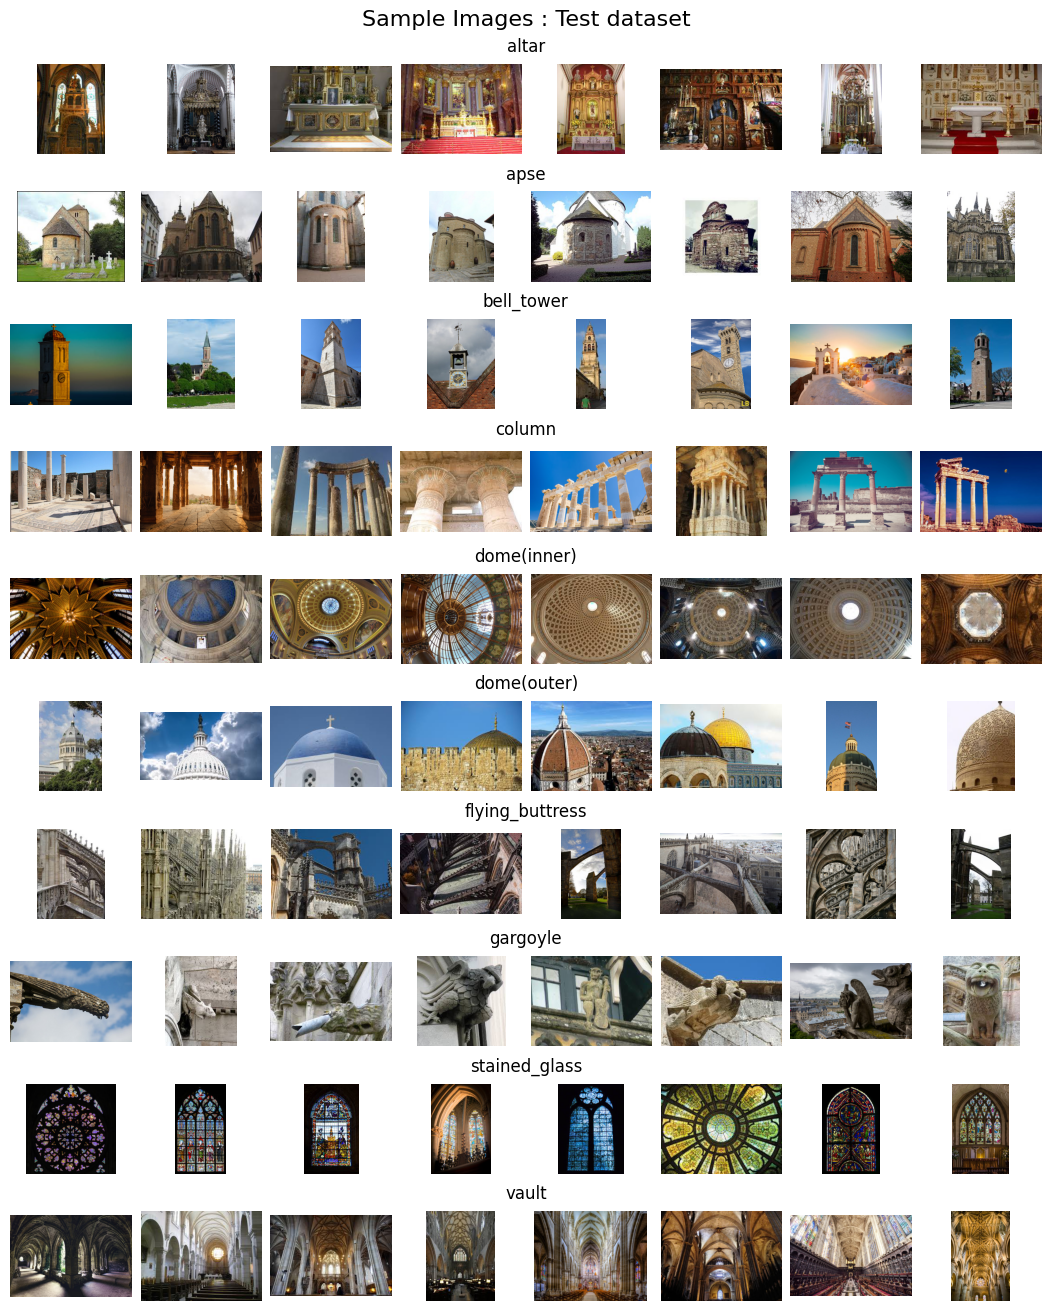

In [16]:
display_images(df_test, 8, 'Test dataset')

In [17]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df2_valid,
    x_col='image',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=128,
    shuffle=False,
    seed=42
)


Found 2109 validated image filenames belonging to 11 classes.


2. Select an CNN architecture of your choice to train the CV model. Configure the architecture for transfer learning, set up a TensorFlow environment for the selected backbone architecture, and load pre-trained weights  
__Note__: Algorithm or architecture selection is an important step in the training of ML models, so select the one that performs the best on your dataset.  
> &nbsp;  
> To select the specific architecture, we'll run the training on several architecture: MobileNet V3 (Large and Small) as well as VGG16.  Time and computing resources prevented further investigation for this exercise.  
> &nbsp;
  
3. Deep learning models tend to work well with large amounts (millions of images) of data, but we may not always have enough data to train a deep learning model from scratch. Transfer learning techniques allow us to train and fine-tune large deep learning architectures using limited data.  
__Hint__: For transfer learning, use pre-trained CNN weights and freeze all convolutional layers' weights.  
  
4. As of now, CNN architecture has been configured for our model. Modify the top of this architecture to work with our dataset by:  
   * Adding an appropriate number of dense layers with an activation function.  
   * Using dropout for regularization.  

   __Note__: It is important to understand that these parameters are hyperparameters that must be tuned.  
> &nbsp;  
> We'll use the `mish` activation function on trainable hidden layers, as it has been shown to perform significantly better during training than ReLU, leaky-ReLU, tanh, or signmoid functions.  
> &nbsp;

5. Compile the model with the right set of parameters like optimizer, loss function, and metric  
> &nbsp;  
> We'll use 3 metrics to track progress:  "Top-1 accuracy", precision, and recall.  
> &nbsp;  

In [18]:
import tensorflow

# Build or load a model if it was previously saved in {data_path}/models
def build_or_load_model(pre_trained_model: tensorflow.keras.Model,
                        num_classes: int,
                        name: str = None) -> tensorflow.keras.Model:
    try:
      model = tensorflow.keras.models.load_model(f"{models_path}/{name}.keras")
    except OSError:
      pre_trained_model.trainable = False
      model = Sequential([
        pre_trained_model,
        Flatten(),
        Dense(256, activation='mish'),
        Dropout(0.3),
        Dense(128, activation='mish'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
      ], name=name)
      model.compile(
        optimizer=Adam(),
        loss='categorical_crossentropy',
        metrics=[     # Older versions of Keras don't define some metrics as strings
          tensorflow.keras.metrics.TopKCategoricalAccuracy(k=1, name='accuracy'),
          tensorflow.keras.metrics.Precision(name='precision'),
          tensorflow.keras.metrics.Recall(name='recall')]
      )
    model.summary()
    return model

6. Define your callback class to stop the training once validation accuracy reaches a certain number of your choice  
> &nbsp;  
> We use both `EarlyStopping` and `ReduceLROnPlateau` to control learning rate and training termination.  
> &nbsp;  

In [ ]:
# Define the callbacks for the model
import tensorflow
def callbacks(monitor: str = 'val_accuracy', es_patience=20, lr_patience=7) -> List[tensorflow.keras.callbacks.Callback]:
    # Early stopping and learning rate reduction
    # if the monitor string is anything but 'loss' or 'val_loss', then the mode
    # should be 'max', otherwise 'min'
    if (monitor != 'loss' and monitor != 'val_loss'):
        mode = 'max'
    else:
        mode = 'min'
    return [
        tensorflow.keras.callbacks.EarlyStopping(
            monitor=monitor,
            patience=es_patience,
            restore_best_weights=True,
            verbose=2,
            mode=mode),
        tensorflow.keras.callbacks.ReduceLROnPlateau(
            monitor=monitor,
            factor=0.3,
            patience=lr_patience,
            verbose=2,
            min_lr=1e-6,
            mode=mode)]

In [ ]:
# Build the model
model_mnv3l = build_or_load_model(
    tensorflow.keras.applications.MobileNetV3Large(include_top=False, weights='imagenet', input_shape=(224, 224, 3)),
    len(df_train['label'].unique()),
    name='MobileNetV3Large')

Model: "MobileNetV3Large"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Function  (None, 7, 7, 960)         2996352   
 al)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 47040)             0         
                                                                 
 dense_12 (Dense)            (None, 256)               12042496  
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 128)               32896     
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                  

7. Setup the train or test dataset directories and review the number of image samples for the train and test datasets for each class  
> &nbsp;  
> This was actually done earlier.   It's interesting to note that the `portal` class is "missing" from the test dataset (but present in training/validation).  
> &nbsp;  

8. Train the model without augmentation while continuously monitoring the validation accuracy

In [ ]:
# Train the model and keep track and report compute time, and save the resulting
# model
def model_fit(model: tensorflow.keras.models.Model,
              train_generator: tensorflow.data.Dataset,
              valid_generator: tensorflow.data.Dataset,
              max_epochs: int,
              callbacks: List[tensorflow.keras.callbacks.Callback],
              **kwargs):
  import time
  start = time.time()
  history = model.fit(train_generator,
                     validation_data=valid_generator,
                     epochs=max_epochs,
                     callbacks=callbacks,
                     **kwargs)
  end = time.time()
  training_time = end - start
  print(f'{model.name} Training time: {training_time // 60} min {training_time % 60:.2f} sec')
  model.save(f'{models_path}/{model.name}.keras')
  return history

In [ ]:
history = model_fit(model_mnv3l, train_generator, valid_generator, max_epochs, callbacks())

Epoch 1/200
66/66 [==============================] - 83s 1s/step - loss: 2.4973 - accuracy: 0.2356 - precision: 0.3273 - recall: 0.0427 - val_loss: 1.8431 - val_accuracy: 0.3812 - val_precision: 0.9189 - val_recall: 0.0806 - lr: 0.0010
Epoch 2/200
66/66 [==============================] - 77s 1s/step - loss: 1.8751 - accuracy: 0.3633 - precision: 0.7364 - recall: 0.1156 - val_loss: 1.6189 - val_accuracy: 0.4685 - val_precision: 0.8737 - val_recall: 0.1607 - lr: 0.0010
Epoch 3/200
66/66 [==============================] - 78s 1s/step - loss: 1.7811 - accuracy: 0.3893 - precision: 0.7153 - recall: 0.1546 - val_loss: 1.6087 - val_accuracy: 0.4528 - val_precision: 0.8481 - val_recall: 0.2172 - lr: 0.0010
Epoch 4/200
66/66 [==============================] - 78s 1s/step - loss: 1.7168 - accuracy: 0.4110 - precision: 0.7145 - recall: 0.1843 - val_loss: 1.5228 - val_accuracy: 0.4860 - val_precision: 0.8166 - val_recall: 0.2195 - lr: 0.0010
Epoch 5/200
66/66 [==============================] - 77s

In [ ]:
def f1(prec_list: List[float], rec_list: List[float]) -> List[float]:
    return [
        2 * (prec * rec) / (prec + rec) if prec + rec != 0.0 else 0.0
        for (prec, rec) in zip(prec_list, rec_list)
    ]

def get_predictions(model: Model, generator: ImageDataGenerator) -> Tuple[np.ndarray, np.ndarray]:
    pred = model.predict(generator)
    pred_labels = np.argmax(pred, axis=1)   # Turn "one-hot encoding"-like probabilities
                                            # into integer encoding for easier comparison
                                            # with true labels
    return pred, pred_labels

def quality_scores(pred_labels: np.ndarray, predictions: np.ndarray, generator: ImageDataGenerator) -> Dict[str, float]:
    loss_func = tensorflow.keras.losses.SparseCategoricalCrossentropy()
    retval = {}
    retval['accuracy'] = sklearn.metrics.accuracy_score(generator.labels, pred_labels)
    retval['precision'] = sklearn.metrics.precision_score(generator.labels, pred_labels, average='macro', zero_division=0)
    retval['recall'] = sklearn.metrics.recall_score(generator.labels, pred_labels, average='macro')
    retval['f1_score'] = 2 * (retval['precision'] * retval['recall']) / (retval['precision'] + retval['recall'])
    retval['loss'] = loss_func(np.array(generator.labels), predictions)
    return retval

def training_subplot(hist, metric: str, plotnum: int, lim = None, test_val = None):
    sp = plt.subplot(3, 2, plotnum)
    metric_nm = metric.replace('_',' ').capitalize()
    plt.plot(hist.history[metric], label='Training')
    plt.plot(hist.history['val_' + metric], label='Validation')
    if (test_val is not None):
        test_lbl = 'Test ' + (f'({test_val:.1%})' if (lim == 1) else f'({test_val:.2f})')
        plt.axhline(y=test_val, label=test_lbl, color='green', linestyle='-')
    plt.xlabel('Epoch')
    plt.ylabel(metric_nm)
    plt.ylim(0, lim)
    plt.xlim(0, len(hist.history['loss']))
    if (lim == 1):
        sp.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
    plt.legend()
    plt.grid(visible=True, which='both', axis='both', linestyle='--', linewidth=0.5, color='grey')
    plt.title(metric_nm)

def training_plot(hist, predicted_labels: np.ndarray, predictions: np.ndarray, generator: ImageDataGenerator, title='Training History'):
    quality = quality_scores(predicted_labels, predictions, generator)
    # Compute the f1 for training and validation
    hist.history['f1_score'] = f1(hist.history['precision'], hist.history['recall'])
    hist.history['val_f1_score'] = f1(hist.history['val_precision'], hist.history['val_recall'])
    # Plot the training history (loss and accuracy) in two subplots
    plt.figure(figsize=(8, 12))
    plt.suptitle(title, fontsize=16, fontweight='bold')
    training_subplot(hist, 'loss', 1, test_val=quality['loss'])
    training_subplot(hist, 'accuracy', 2, 1, test_val=quality['accuracy'])
    training_subplot(hist, 'precision', 3, 1, test_val=quality['precision'])
    training_subplot(hist, 'recall', 4, 1, test_val=quality['recall'])
    training_subplot(hist, 'f1_score', 5, 1, test_val=quality['f1_score'])
    plt.tight_layout()
    plt.show()


In [ ]:
predictions, predicted_labels = get_predictions(model_mnv3l, test_generator)

17/17 [==============================] - 16s 864ms/step


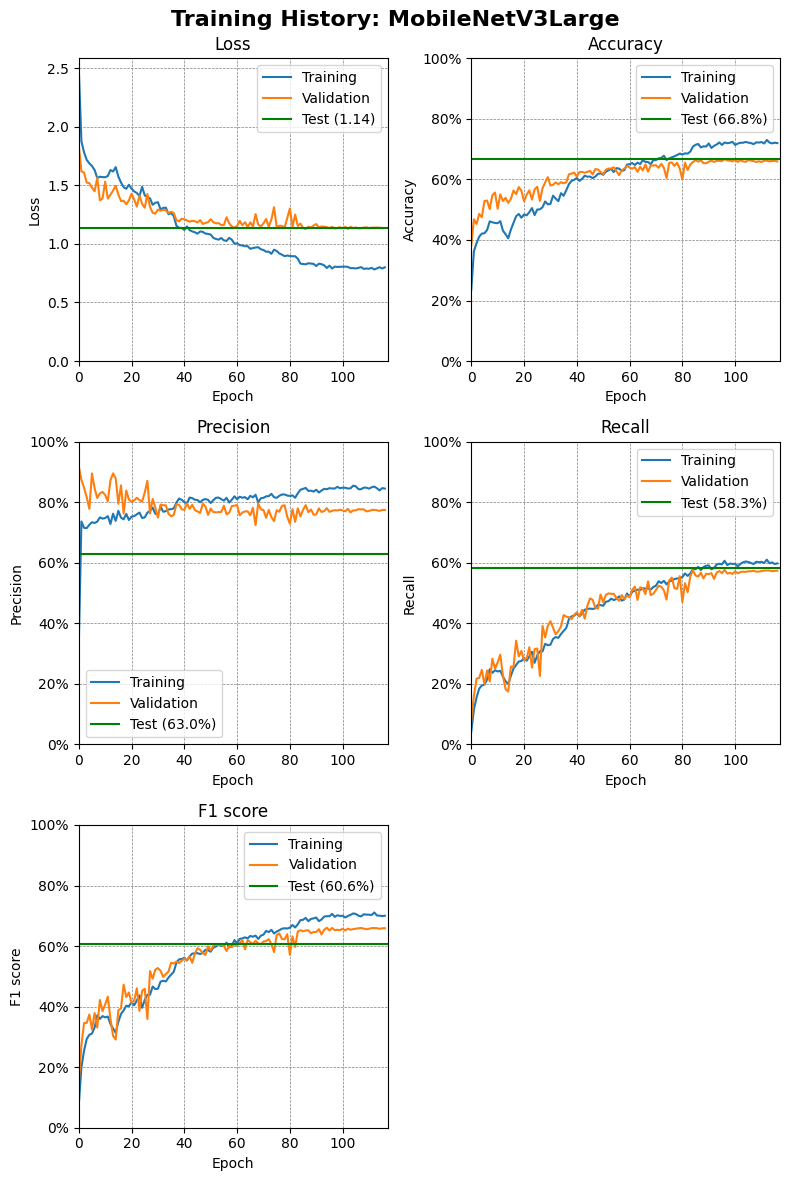

In [ ]:
training_plot(history, predicted_labels, predictions, test_generator, "Training History: MobileNetV3Large")

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

def confusion_matrix_and_classification_report(predicted_labels: np.ndarray, generator: tensorflow.keras.preprocessing.image.DirectoryIterator, title: str):
    class_names = generator.class_indices.keys()
    # Compute the confusion matrix
    cm = confusion_matrix(generator.labels, predicted_labels)
    # Plot the confusion matrix
    cm_display = ConfusionMatrixDisplay(cm, display_labels=class_names)
    cm_display.plot(cmap='Blues', values_format='d', xticks_rotation=45)
    plt.title('Confusion Matrix: ' + title)
    plt.show()
    # Display the classification report
    print(classification_report(generator.labels, predicted_labels, target_names=class_names, zero_division=0))


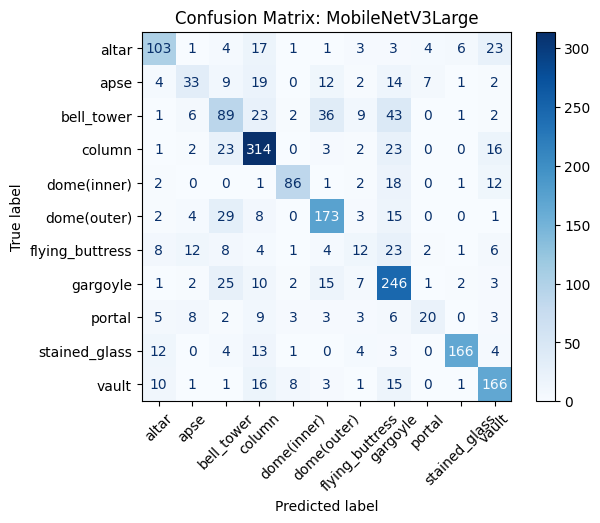

                 precision    recall  f1-score   support

          altar       0.69      0.62      0.65       166
           apse       0.48      0.32      0.38       103
     bell_tower       0.46      0.42      0.44       212
         column       0.72      0.82      0.77       384
    dome(inner)       0.83      0.70      0.76       123
    dome(outer)       0.69      0.74      0.71       235
flying_buttress       0.25      0.15      0.19        81
       gargoyle       0.60      0.78      0.68       314
         portal       0.59      0.32      0.42        62
  stained_glass       0.93      0.80      0.86       207
          vault       0.70      0.75      0.72       222

       accuracy                           0.67      2109
      macro avg       0.63      0.58      0.60      2109
   weighted avg       0.66      0.67      0.66      2109



In [ ]:
confusion_matrix_and_classification_report(predicted_labels, test_generator, 'MobileNetV3Large')

In [ ]:
model_mnv3s = build_or_load_model(
    tensorflow.keras.applications.MobileNetV3Small(include_top=False, weights='imagenet', input_shape=(224, 224, 3)),
    len(df_train['label'].unique()),
    name='MobileNetV3Small')

Model: "MobileNetV3Small"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Function  (None, 7, 7, 576)         939120    
 al)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 28224)             0         
                                                                 
 dense_15 (Dense)            (None, 256)               7225600   
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_16 (Dense)            (None, 128)               32896     
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                  

In [ ]:
history_mnv3s = model_fit(model_mnv3s, train_generator, valid_generator, max_epochs, callbacks())

Epoch 1/200
66/66 [==============================] - 58s 827ms/step - loss: 2.7858 - accuracy: 0.1902 - precision: 0.1430 - recall: 0.0164 - val_loss: 2.0914 - val_accuracy: 0.2764 - val_precision: 0.6667 - val_recall: 9.4832e-04 - lr: 0.0010
Epoch 2/200
66/66 [==============================] - 52s 785ms/step - loss: 2.0783 - accuracy: 0.2826 - precision: 0.7198 - recall: 0.0439 - val_loss: 1.9664 - val_accuracy: 0.3395 - val_precision: 0.9167 - val_recall: 0.0522 - lr: 0.0010
Epoch 3/200
66/66 [==============================] - 52s 789ms/step - loss: 1.9901 - accuracy: 0.3094 - precision: 0.7309 - recall: 0.0828 - val_loss: 1.8600 - val_accuracy: 0.3656 - val_precision: 0.8750 - val_recall: 0.1128 - lr: 0.0010
Epoch 4/200
66/66 [==============================] - 52s 792ms/step - loss: 1.9597 - accuracy: 0.3284 - precision: 0.7239 - recall: 0.1029 - val_loss: 1.7928 - val_accuracy: 0.3902 - val_precision: 0.8679 - val_recall: 0.1527 - lr: 0.0010
Epoch 5/200
66/66 [=====================

In [ ]:
predictions_mnv3s, predicted_labels_mnv3s = get_predictions(model_mnv3s, test_generator)

17/17 [==============================] - 11s 588ms/step


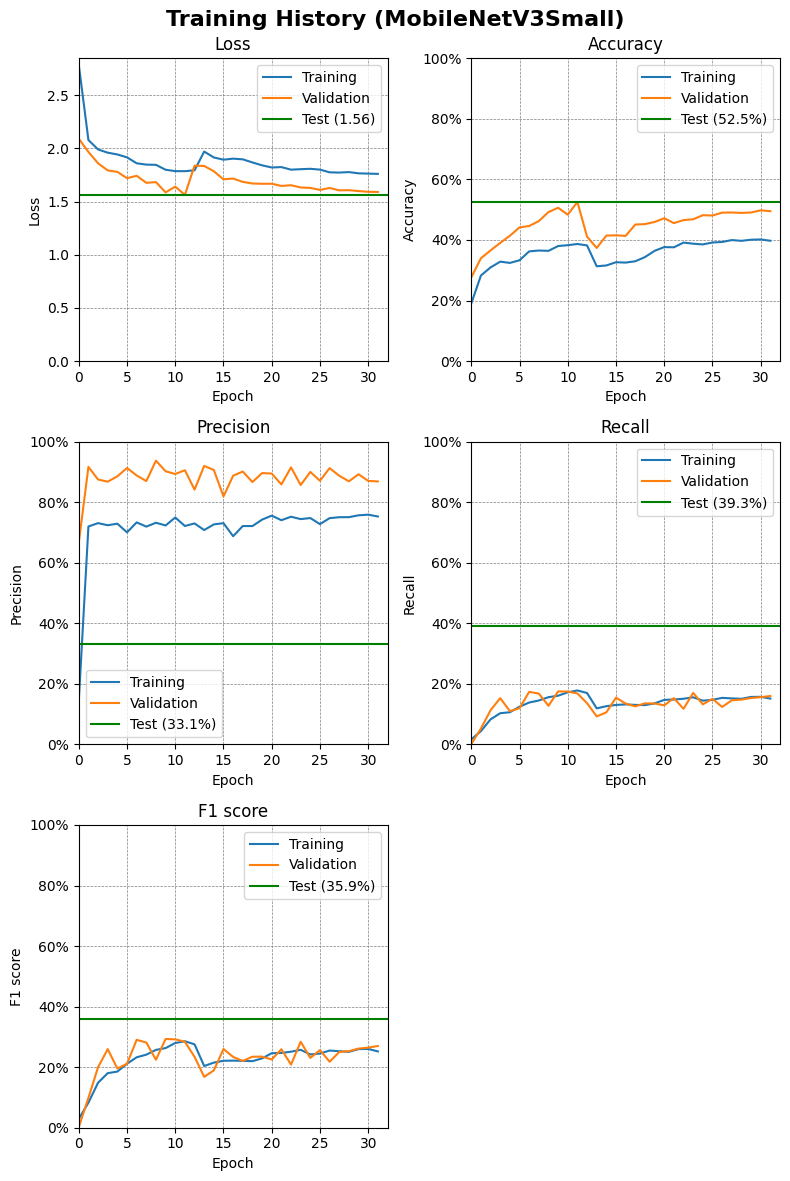

In [ ]:
training_plot(history_mnv3s, predicted_labels_mnv3s, predictions_mnv3s, test_generator, "Training History (MobileNetV3Small)")

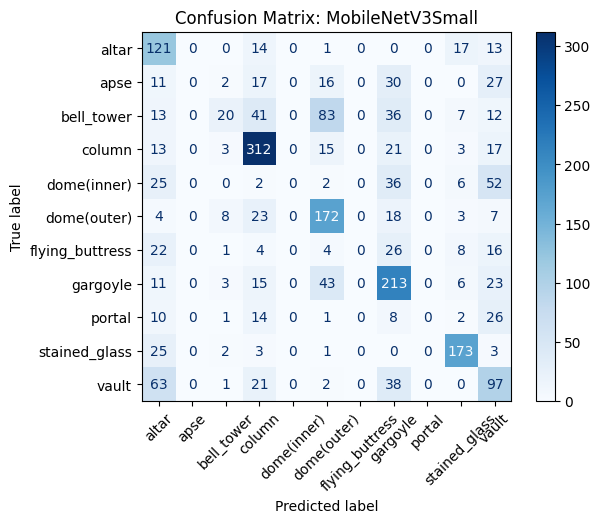

                 precision    recall  f1-score   support

          altar       0.38      0.73      0.50       166
           apse       0.00      0.00      0.00       103
     bell_tower       0.49      0.09      0.16       212
         column       0.67      0.81      0.73       384
    dome(inner)       0.00      0.00      0.00       123
    dome(outer)       0.51      0.73      0.60       235
flying_buttress       0.00      0.00      0.00        81
       gargoyle       0.50      0.68      0.58       314
         portal       0.00      0.00      0.00        62
  stained_glass       0.77      0.84      0.80       207
          vault       0.33      0.44      0.38       222

       accuracy                           0.53      2109
      macro avg       0.33      0.39      0.34      2109
   weighted avg       0.44      0.53      0.46      2109



In [ ]:
confusion_matrix_and_classification_report(predicted_labels_mnv3s, test_generator, 'MobileNetV3Small')

In [ ]:
model_vgg16 = build_or_load_model(
    tensorflow.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3)),
    len(df_train['label'].unique()),
    name='VGG16')

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 25088)             0         
                                                                 
 dense_18 (Dense)            (None, 256)               6422784   
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_19 (Dense)            (None, 128)               32896     
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_20 (Dense)            (None, 11)                1419  

In [ ]:
history_vgg16 = model_fit(model_vgg16, train_generator, valid_generator, max_epochs, callbacks())

Epoch 1/200
66/66 [==============================] - 181s 3s/step - loss: 0.9449 - accuracy: 0.7172 - precision: 0.8212 - recall: 0.6309 - val_loss: 0.3174 - val_accuracy: 0.9099 - val_precision: 0.9449 - val_recall: 0.8620 - lr: 0.0010
Epoch 2/200
66/66 [==============================] - 181s 3s/step - loss: 0.3573 - accuracy: 0.8914 - precision: 0.9258 - recall: 0.8534 - val_loss: 0.2751 - val_accuracy: 0.9208 - val_precision: 0.9392 - val_recall: 0.8938 - lr: 0.0010
Epoch 3/200
66/66 [==============================] - 181s 3s/step - loss: 0.2352 - accuracy: 0.9261 - precision: 0.9471 - recall: 0.9042 - val_loss: 0.2353 - val_accuracy: 0.9303 - val_precision: 0.9433 - val_recall: 0.9151 - lr: 0.0010
Epoch 4/200
66/66 [==============================] - 182s 3s/step - loss: 0.1700 - accuracy: 0.9464 - precision: 0.9622 - recall: 0.9331 - val_loss: 0.2181 - val_accuracy: 0.9374 - val_precision: 0.9494 - val_recall: 0.9260 - lr: 0.0010
Epoch 5/200
66/66 [==============================] -

In [ ]:
predictions_vgg16, predicted_labels_vgg16 = get_predictions(model_vgg16, test_generator)

17/17 [==============================] - 38s 2s/step


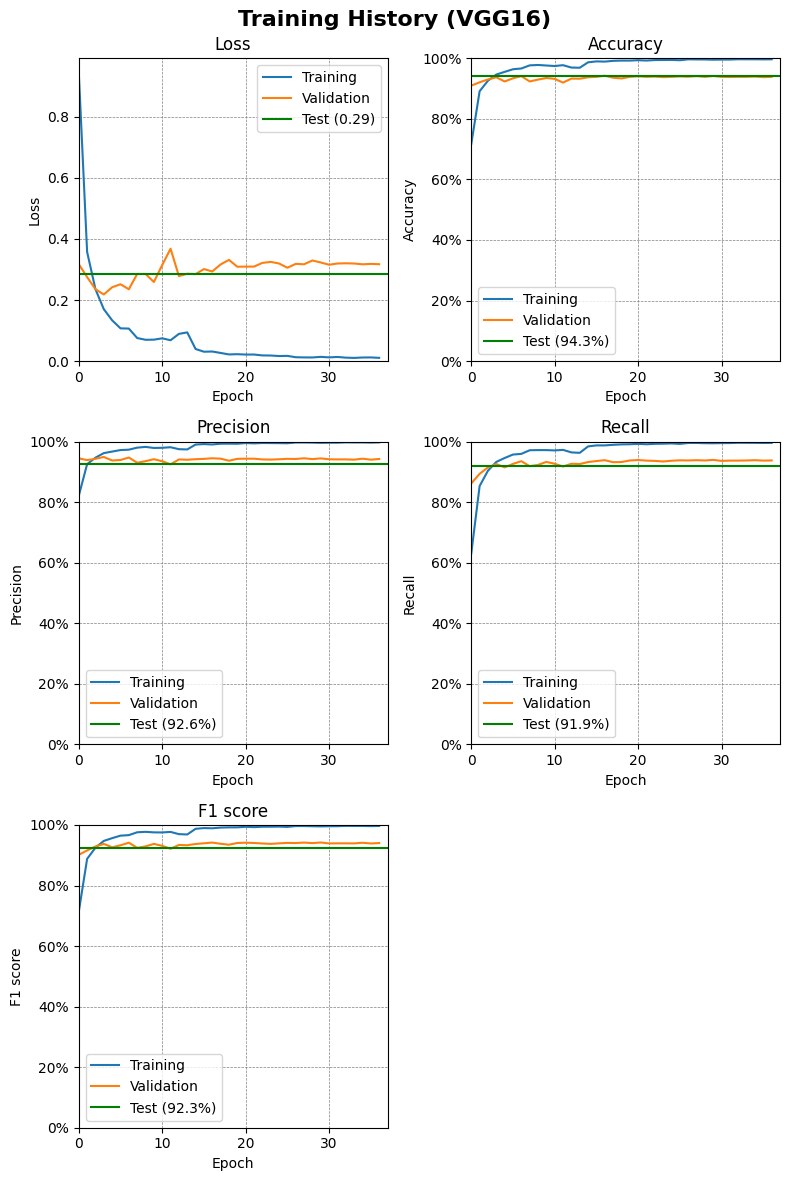

In [89]:
training_plot(history_vgg16, predicted_labels_vgg16, predictions_vgg16, test_generator, "Training History (VGG16)")

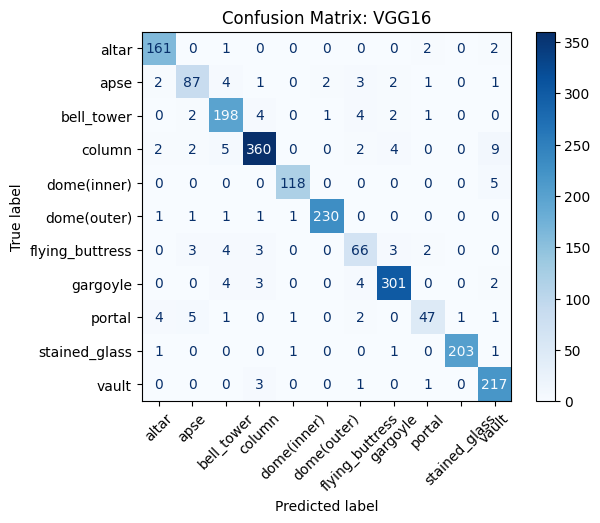

                 precision    recall  f1-score   support

          altar       0.94      0.97      0.96       166
           apse       0.87      0.84      0.86       103
     bell_tower       0.91      0.93      0.92       212
         column       0.96      0.94      0.95       384
    dome(inner)       0.98      0.96      0.97       123
    dome(outer)       0.99      0.98      0.98       235
flying_buttress       0.80      0.81      0.81        81
       gargoyle       0.96      0.96      0.96       314
         portal       0.87      0.76      0.81        62
  stained_glass       1.00      0.98      0.99       207
          vault       0.91      0.98      0.94       222

       accuracy                           0.94      2109
      macro avg       0.93      0.92      0.92      2109
   weighted avg       0.94      0.94      0.94      2109



In [ ]:
confusion_matrix_and_classification_report(predicted_labels_vgg16, test_generator, 'VGG16')

10. Train the model with augmentation and keep monitoring validation accuracy  
__Note__: Choose carefully the number of epochs, steps per epoch, and validation steps based on your computer configuration  
> &nbsp;  
> We'll only do augmentation for the VGG16 pre-trained network as it clearly outperforms the other architectures we've tried.  
> &nbsp;
  
11. Visualize training and validation accuracy on the y-axis against each epoch on the x-axis to see if the model overfits after a certain epoch  
> &nbsp;  
> This was done several times earlier, showing accuracy, precision, recall, loss, and F1 score.  In addition, we produced confusion matrices for each tested pre-trained model.  In each case, the combination of early stopping and reducing learning rate on plateau seems to have eliminated overfitting.  
> &nbsp;

In [ ]:
# Build a train/validate generator pair from the train folder using data
# augmentation for the train data set and also balanced weights for the
# classes

aug_train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    fill_mode='nearest'
)

aug_train_generator = aug_train_datagen.flow_from_dataframe(
    dataframe=df2_train,
    x_col='image',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=128,
    shuffle=True,
    seed=42
)

aug_valid_datagen = ImageDataGenerator(rescale=1./255)

aug_valid_generator = aug_valid_datagen.flow_from_dataframe(
    dataframe=df2_valid,
    x_col='image',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size= 128,
    shuffle=False,
    seed=42
)

Found 8433 validated image filenames belonging to 11 classes.
Found 2109 validated image filenames belonging to 11 classes.


In [ ]:
# Compute class weights based on df_train
class_counts = df_train['label'].value_counts().to_dict()
class_weights = {i: 1 / v for i, (k, v) in enumerate(class_counts.items())}
sum_weights = sum(class_weights.values())
class_weights = {k: v / sum_weights for k, v in class_weights.items()}

In [ ]:
model_vgg16_aug = build_or_load_model(
    tensorflow.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3)),
    len(df_train['label'].unique()),
    name='VGG16_aug'
)

Model: "VGG16_aug"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_7 (Flatten)         (None, 25088)             0         
                                                                 
 dense_21 (Dense)            (None, 256)               6422784   
                                                                 
 dropout_14 (Dropout)        (None, 256)               0         
                                                                 
 dense_22 (Dense)            (None, 128)               32896     
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                                 
 dense_23 (Dense)            (None, 11)                14

In [ ]:
history_vgg16_aug = model_fit(
    model_vgg16_aug,
    aug_train_generator,
    aug_valid_generator,
    max_epochs,
    callbacks(),
    class_weight=class_weights
)

Epoch 1/200
66/66 [==============================] - 244s 4s/step - loss: 0.1264 - accuracy: 0.5289 - precision: 0.6673 - recall: 0.4031 - val_loss: 0.6337 - val_accuracy: 0.8094 - val_precision: 0.8896 - val_recall: 0.6880 - lr: 0.0010
Epoch 2/200
66/66 [==============================] - 242s 4s/step - loss: 0.0595 - accuracy: 0.7366 - precision: 0.8516 - recall: 0.6337 - val_loss: 0.4048 - val_accuracy: 0.8843 - val_precision: 0.9349 - val_recall: 0.8108 - lr: 0.0010
Epoch 3/200
66/66 [==============================] - 242s 4s/step - loss: 0.0486 - accuracy: 0.7783 - precision: 0.8665 - recall: 0.6975 - val_loss: 0.3372 - val_accuracy: 0.9066 - val_precision: 0.9422 - val_recall: 0.8582 - lr: 0.0010
Epoch 4/200
66/66 [==============================] - 241s 4s/step - loss: 0.0475 - accuracy: 0.7888 - precision: 0.8635 - recall: 0.7184 - val_loss: 0.3284 - val_accuracy: 0.9033 - val_precision: 0.9369 - val_recall: 0.8663 - lr: 0.0010
Epoch 5/200
66/66 [==============================] -

In [91]:
predictions_vgg16_aug, predicted_labels_vgg16_aug = get_predictions(model_vgg16_aug, test_generator)

17/17 [==============================] - 38s 2s/step


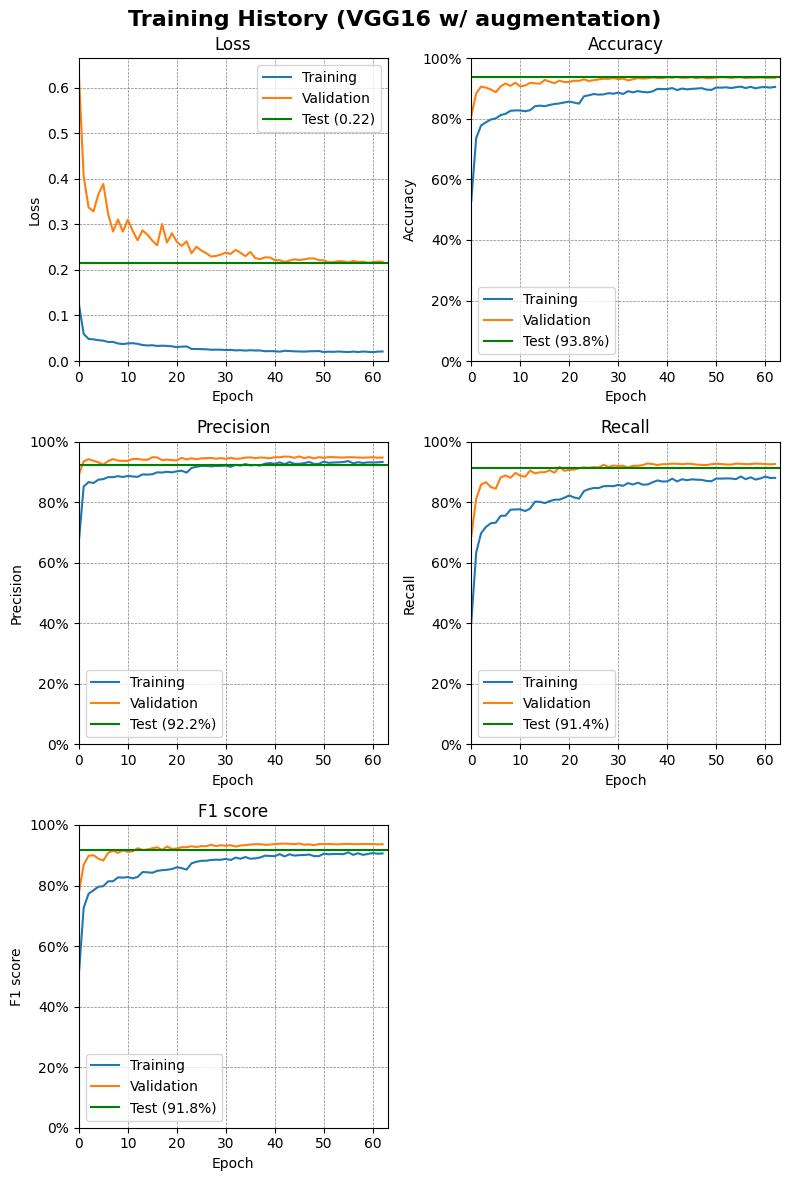

In [92]:
training_plot(history_vgg16_aug, predicted_labels_vgg16_aug, predictions_vgg16_aug, test_generator, "Training History (VGG16 w/ augmentation)")

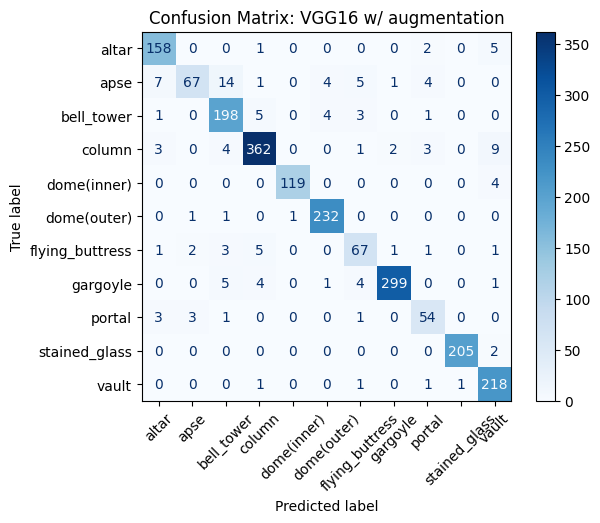

                 precision    recall  f1-score   support

          altar       0.91      0.95      0.93       166
           apse       0.92      0.65      0.76       103
     bell_tower       0.88      0.93      0.90       212
         column       0.96      0.94      0.95       384
    dome(inner)       0.99      0.97      0.98       123
    dome(outer)       0.96      0.99      0.97       235
flying_buttress       0.82      0.83      0.82        81
       gargoyle       0.99      0.95      0.97       314
         portal       0.82      0.87      0.84        62
  stained_glass       1.00      0.99      0.99       207
          vault       0.91      0.98      0.94       222

       accuracy                           0.94      2109
      macro avg       0.92      0.91      0.92      2109
   weighted avg       0.94      0.94      0.94      2109



In [ ]:
confusion_matrix_and_classification_report(predicted_labels_vgg16_aug, test_generator, 'VGG16 w/ augmentation')